<a href="https://colab.research.google.com/github/JahidulHasanRabbi/Thesis_hypbrid_freamwork/blob/main/Rice_Leaf_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Dataset Thesis/RiceLeaf 2.zip' '/content'

In [ ]:
!unzip -q 'RiceLeaf 2.zip'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL
import os
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from keras.applications import InceptionV3, ResNet152V2, MobileNetV2
from keras import initializers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import seaborn as sns

# **Dataset**

In [ ]:
base_dir = '/content/RiceLeaf 2'
test_dir = '/content/RiceLeaf 2/validation'
train_dir = '/content/RiceLeaf 2/train'
print(os.listdir(base_dir))

['validation', 'train']


# Image Shape

In [ ]:
image_size = (224, 224)
batch_size = 128
print(image_size)

(224, 224)


# Dataset

In [ ]:
dataset_directory = train_dir

class_counts = {}

for class_name in os.listdir(dataset_directory):
    class_path = os.path.join(dataset_directory, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
def count_images_in_folder(folder_path):
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                total_images += 1
    return total_images

total_train_images = count_images_in_folder(train_dir)
total_test_images = count_images_in_folder(test_dir)

print(f"Total train images: {total_train_images}")
print(f"Total test images: {total_test_images}")

Total train images: 2167
Total test images: 543


In [ ]:
train_directory = train_dir
Name = sorted([item for item in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, item))])
print(Name)
N=[]
for i in range(len(Name)):
    N+=[i]
normal_mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))
print(reverse_mapping)
def mapper(value):
    return reverse_mapping[value]

['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']
{0: 'bacterial_leaf_blight', 1: 'brown_spot', 2: 'healthy', 3: 'leaf_blast', 4: 'leaf_scald', 5: 'narrow_brown_spot'}


In [ ]:
num_classes = len(class_counts)
colors = [plt.cm.jet(i / float(num_classes)) for i in range(num_classes)]

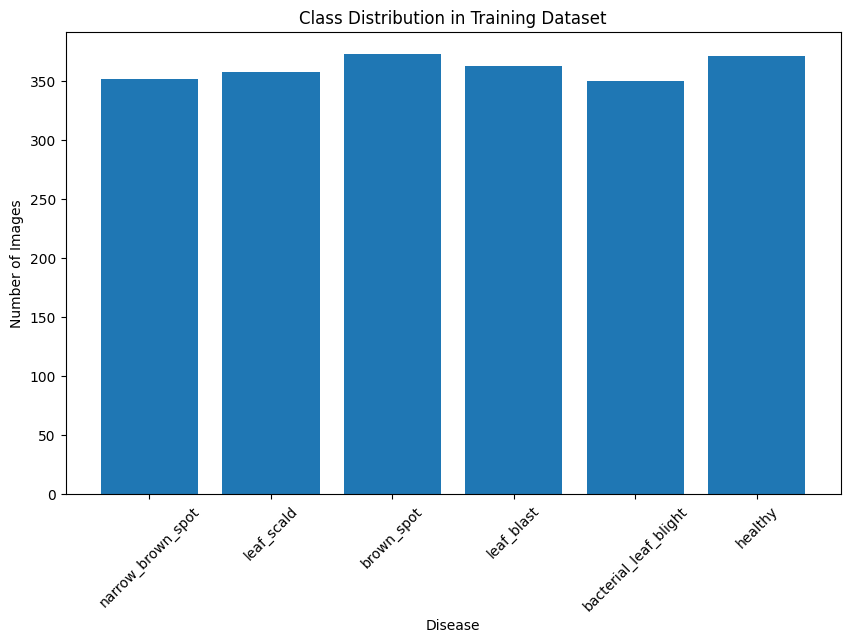

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_counts.keys(), class_counts.values())
ax.set_xlabel('Disease')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()

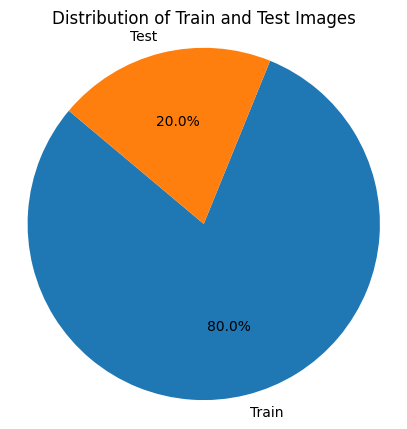

In [ ]:
labels = ['Train', 'Test']
sizes = [total_train_images, total_test_images]

plt.figure(figsize=(5, 5))
plt.pie(sizes , labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Train and Test Images')
plt.axis('equal')
plt.show()

In [ ]:
categories = []
train = []
test = []

folders = os.listdir(train_dir)
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join(train_dir, f))))

folders = os.listdir(test_dir)
for f in folders:
    test.append(len(os.listdir(os.path.join(test_dir, f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'test': test
                    })

data_count

,categories,train,test
0,narrow_brown_spot,352,88
1,leaf_scald,358,90
2,brown_spot,373,93
3,leaf_blast,363,91
4,bacterial_leaf_blight,350,88
5,healthy,371,93


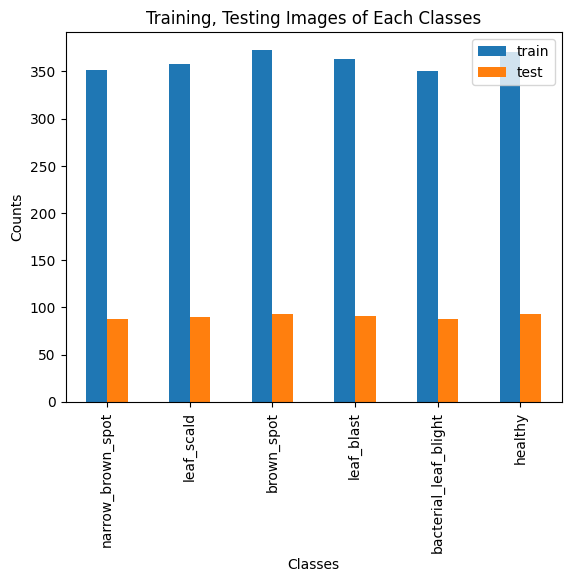

In [ ]:
data_count.plot.bar(x='categories', title="Training, Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

# **Rescaling and Dataset Split**

In [ ]:
image_gen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
train_data = image_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    # subset='training'
)

test_data = image_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    # subset='validation'
)

print(len(train_data))
print(len(test_data))

Found 2167 images belonging to 6 classes.
Found 543 images belonging to 6 classes.
17
5


In [ ]:
num_classes = 6

# **Inception V3**

In [ ]:
K.clear_session()

model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
model.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = model.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(.0005))(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu', kernel_initializer=initializers.he_normal(seed=None))(x)
x = Dropout(0.25)(x)
predictions = Dense(num_classes,  kernel_initializer="glorot_uniform", activation='softmax')(x)

model = Model(inputs = model.input, outputs=predictions)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    TensorBoard(log_dir='./logs')
]

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001 ,amsgrad=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=callbacks
)

Epoch 1/100
17/17 [==============================] - 32s 882ms/step - loss: 1.9987 - accuracy: 0.3909 - val_loss: 1.2053 - val_accuracy: 0.6961
Epoch 2/100
17/17 [==============================] - 7s 407ms/step - loss: 1.3144 - accuracy: 0.6096 - val_loss: 0.9638 - val_accuracy: 0.7274
Epoch 3/100
17/17 [==============================] - 8s 470ms/step - loss: 1.1004 - accuracy: 0.6816 - val_loss: 0.8247 - val_accuracy: 0.8140
Epoch 4/100
17/17 [==============================] - 8s 439ms/step - loss: 0.9603 - accuracy: 0.7277 - val_loss: 0.7455 - val_accuracy: 0.8232
Epoch 5/100
17/17 [==============================] - 8s 429ms/step - loss: 0.8997 - accuracy: 0.7591 - val_loss: 0.7311 - val_accuracy: 0.8195
Epoch 6/100
17/17 [==============================] - 7s 396ms/step - loss: 0.8361 - accuracy: 0.7780 - val_loss: 0.6562 - val_accuracy: 0.8508
Epoch 7/100
17/17 [==============================] - 10s 599ms/step - loss: 0.7886 - accuracy: 0.7970 - val_loss: 0.6556 - val_accuracy: 0.85

In [ ]:
model.save("InceptionV#.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Model Evaluation**

In [ ]:
def accuracy(history):
  get_acc = history.history['accuracy']
  value_acc = history.history['val_accuracy']

  epochs = range(len(get_acc))
  plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
  plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
  plt.title('Training vs validation accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

def loss(history):
  get_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  epochs = range(len(get_loss))
  plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
  plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
  plt.title('Training vs validation loss')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

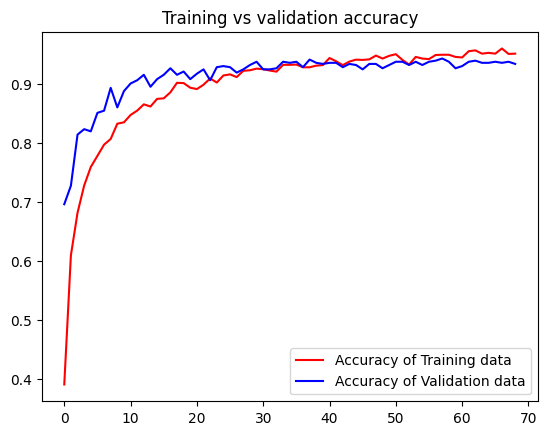

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy(history)

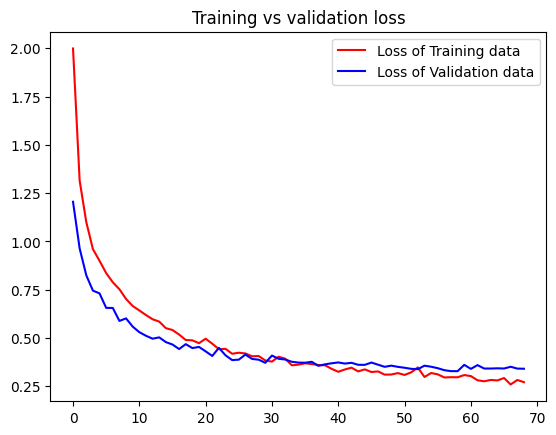

<Figure size 640x480 with 0 Axes>

In [ ]:
loss(history)

# **Predication**

In [ ]:
test_images, true_labels = next(test_data)

predicted_labels = model.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

class_labels = list(test_data.class_indices.keys())

confusion = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)

report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=class_labels)
print(report)
print("Confusion Matrix:")
print(confusion)

4/4 [==============================] - 4s 48ms/step
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00        16
           brown_spot       0.83      0.83      0.83        24
              healthy       0.89      1.00      0.94        24
           leaf_blast       0.94      0.80      0.86        20
           leaf_scald       1.00      1.00      1.00        23
    narrow_brown_spot       1.00      1.00      1.00        21

             accuracy                           0.94       128
            macro avg       0.94      0.94      0.94       128
         weighted avg       0.94      0.94      0.94       128

Confusion Matrix:
[[16  0  0  0  0  0]
 [ 0 20  3  1  0  0]
 [ 0  0 24  0  0  0]
 [ 0  4  0 16  0  0]
 [ 0  0  0  0 23  0]
 [ 0  0  0  0  0 21]]


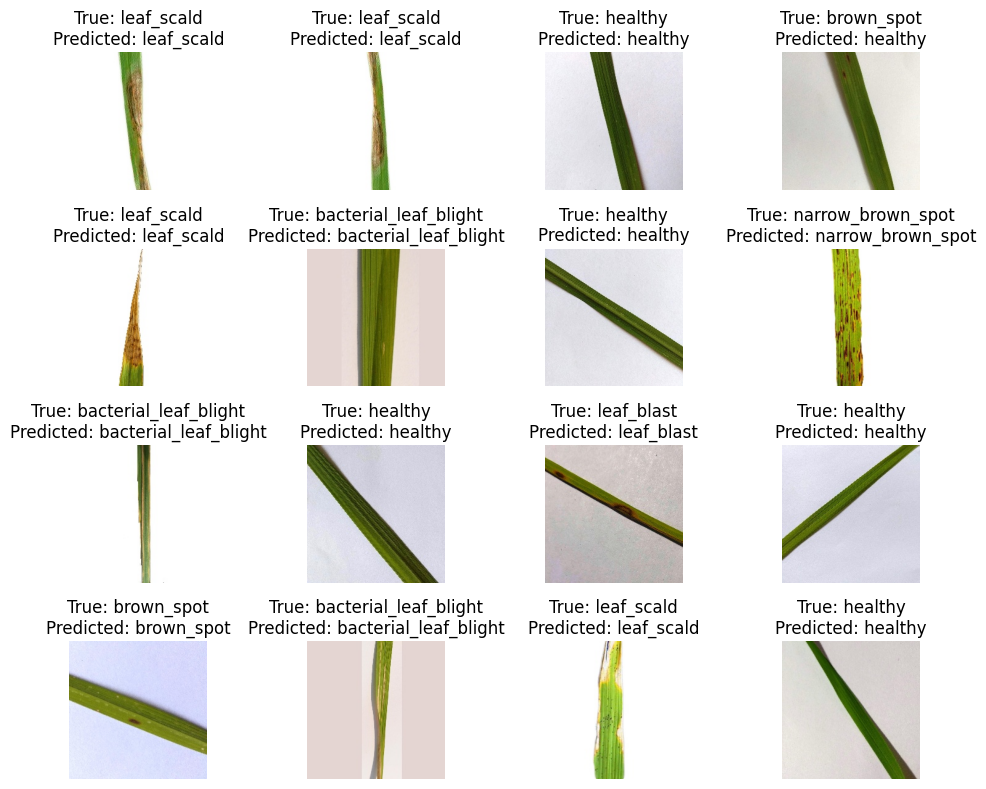

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(16):
    true_label = class_labels[np.argmax(true_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

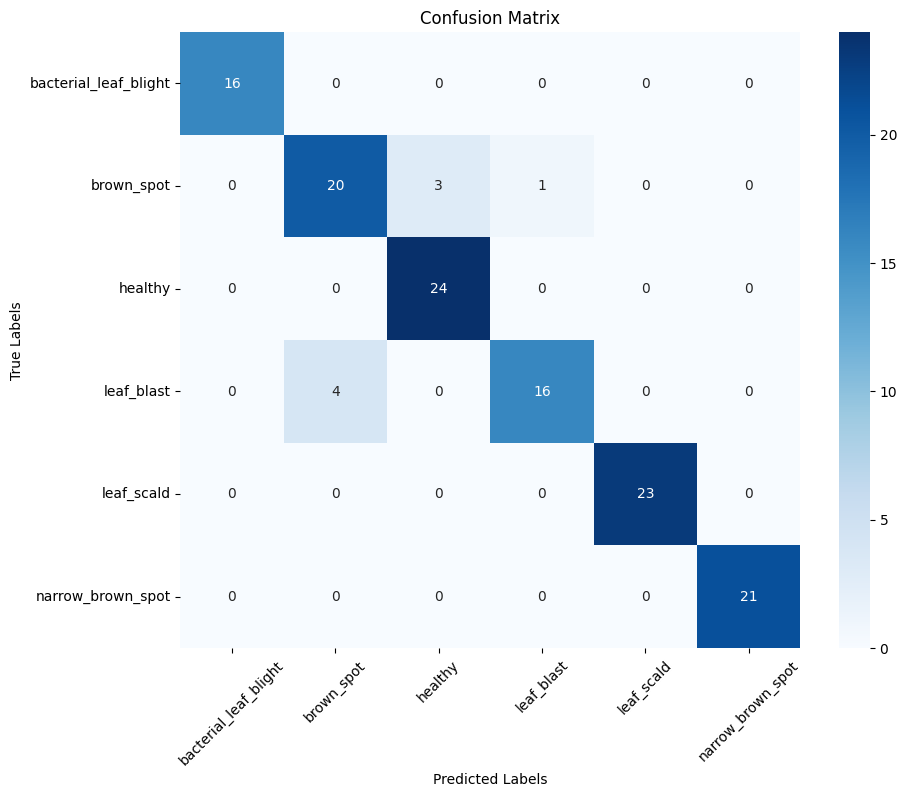

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

# **Predection**

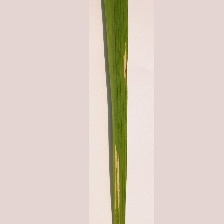

In [ ]:
image_path = '/content/RiceLeaf 2/validation/bacterial_leaf_blight/bacterial_val (1).JPG'
image = cv2.imread(image_path)
cv2_imshow(image)

In [ ]:
image = load_img(image_path)
image=img_to_array(image)
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
print(value)
print("Prediction is {}.".format(move_name))

1/1 [==============================] - 2s 2s/step
0
Prediction is bacterial_leaf_blight.


# **VGG16**

In [ ]:
K.clear_session()
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model1.trainable = False

In [ ]:
x = model1.output
x = Flatten()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=model1.input, outputs=predictions)

In [ ]:
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001 ),
    metrics=['accuracy']
)

In [ ]:
history1 = model1.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=callbacks
)

Epoch 1/100
17/17 [==============================] - 56s 2s/step - loss: 2.9858 - accuracy: 0.4269 - val_loss: 0.9571 - val_accuracy: 0.6611
Epoch 2/100
17/17 [==============================] - 12s 689ms/step - loss: 0.8631 - accuracy: 0.6811 - val_loss: 0.7147 - val_accuracy: 0.6998
Epoch 3/100
17/17 [==============================] - 13s 751ms/step - loss: 0.6740 - accuracy: 0.7328 - val_loss: 0.6340 - val_accuracy: 0.7643
Epoch 4/100
17/17 [==============================] - 15s 896ms/step - loss: 0.5599 - accuracy: 0.7923 - val_loss: 0.5267 - val_accuracy: 0.7937
Epoch 5/100
17/17 [==============================] - 15s 883ms/step - loss: 0.4704 - accuracy: 0.8256 - val_loss: 0.4861 - val_accuracy: 0.8250
Epoch 6/100
17/17 [==============================] - 12s 702ms/step - loss: 0.4160 - accuracy: 0.8500 - val_loss: 0.4602 - val_accuracy: 0.8379
Epoch 7/100
17/17 [==============================] - 12s 704ms/step - loss: 0.3707 - accuracy: 0.8680 - val_loss: 0.4301 - val_accuracy: 0.

In [ ]:
model.save("Vgg16.keras")

# **Evaluation**

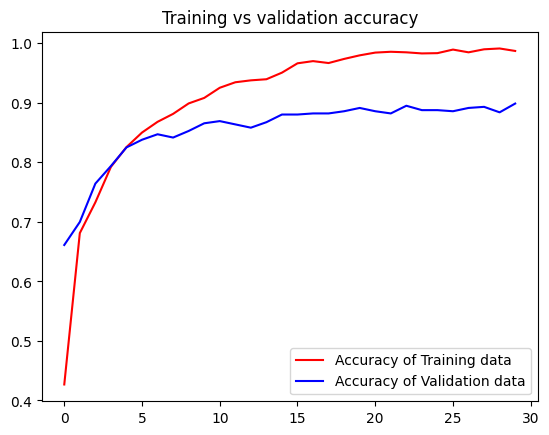

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy(history1)

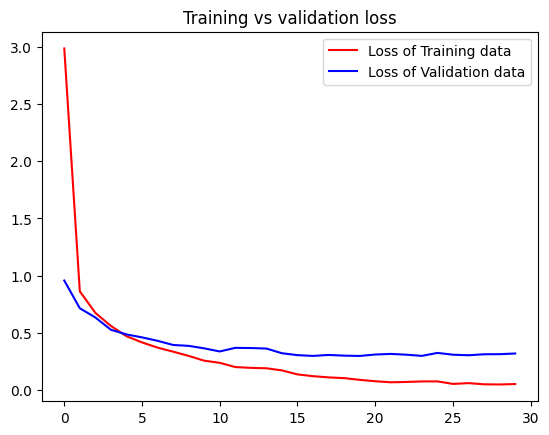

<Figure size 640x480 with 0 Axes>

In [ ]:
loss(history1)

# **Predication**

In [ ]:
test_images, true_labels = next(test_data)

predicted_labels = model1.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

class_labels = list(test_data.class_indices.keys())

confusion = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)
report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=class_labels)
print(report)
print("Confusion Matrix:")
print(confusion)

4/4 [==============================] - 0s 140ms/step
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00        21
           brown_spot       0.80      0.89      0.84        18
              healthy       0.88      0.88      0.88        25
           leaf_blast       0.75      0.71      0.73        17
           leaf_scald       0.96      1.00      0.98        23
    narrow_brown_spot       1.00      0.92      0.96        24

             accuracy                           0.91       128
            macro avg       0.90      0.90      0.90       128
         weighted avg       0.91      0.91      0.91       128

Confusion Matrix:
[[21  0  0  0  0  0]
 [ 0 16  1  1  0  0]
 [ 0  1 22  2  0  0]
 [ 0  3  2 12  0  0]
 [ 0  0  0  0 23  0]
 [ 0  0  0  1  1 22]]


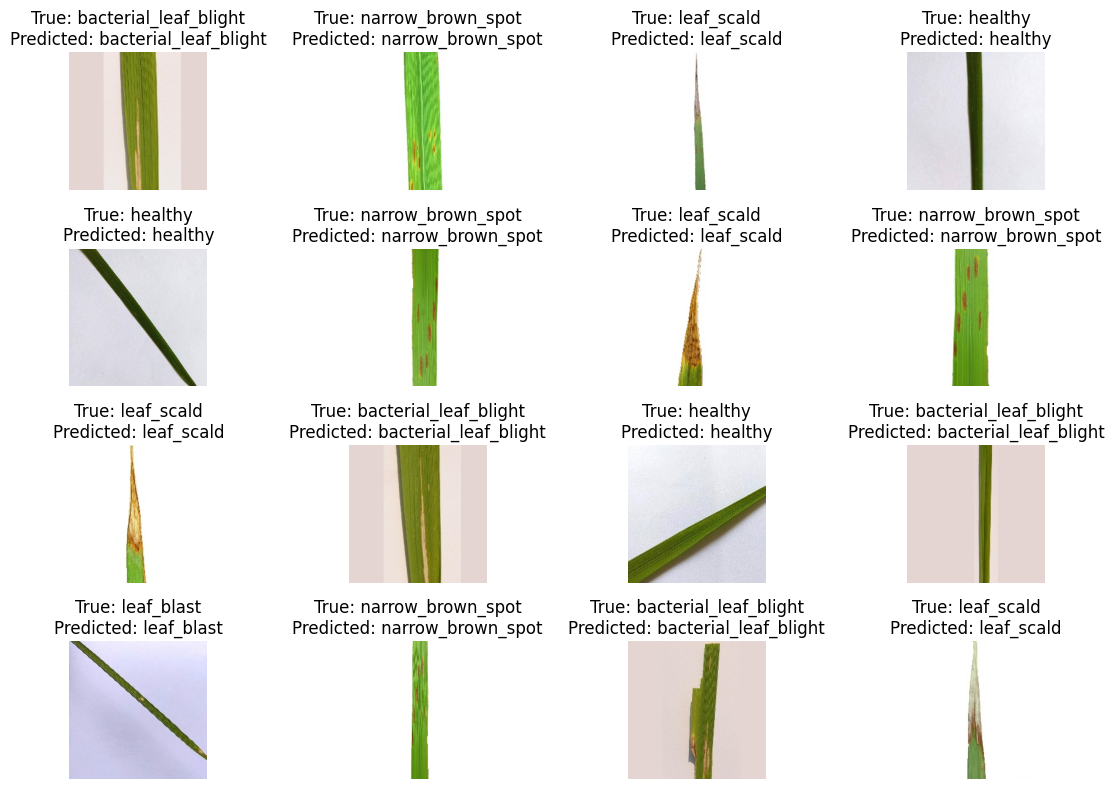

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(16):
    true_label = class_labels[np.argmax(true_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")

    plt.axis('off')

plt.tight_layout()
plt.show()

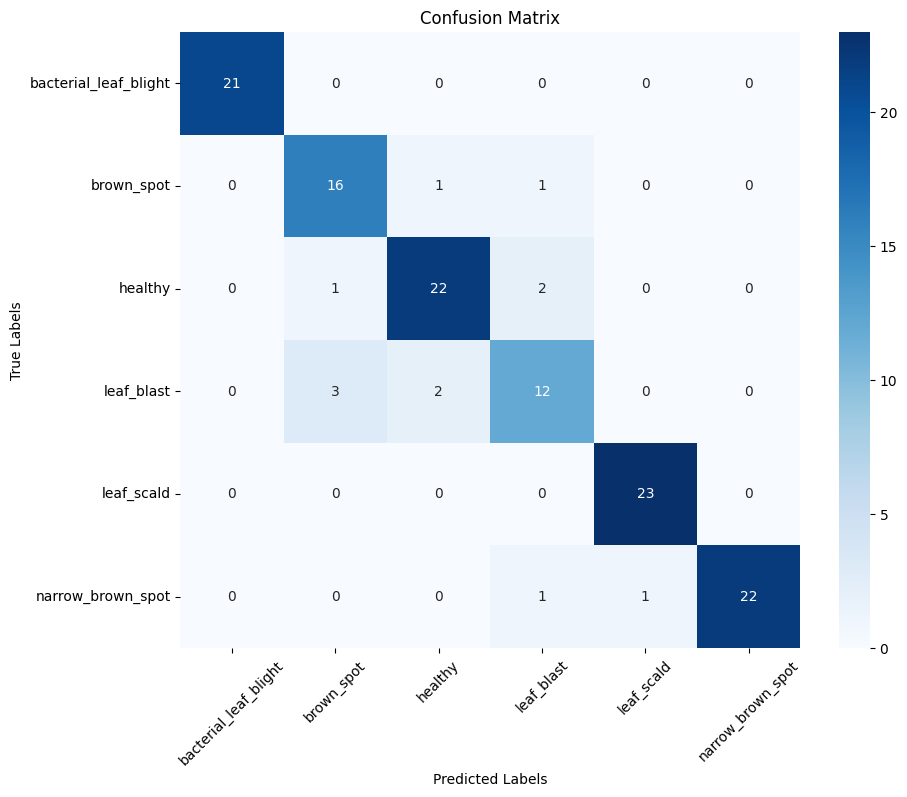

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()


In [ ]:
image=load_img("/content/RiceLeaf 2/train/leaf_blast/leaf_blast (103).jpg",target_size=(224,224))

image=img_to_array(image)
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)
prediction=model.predict(prediction_image)
predicted_classes = np.argmax(prediction, axis=1)

value=np.argmax(prediction)
print(predicted_classes)
print(value)

1/1 [==============================] - 1s 743ms/step
[3]
3


In [ ]:
predictions_list = []
labels_list = []

for x, y in test_dataset:
    predictions_list.append(np.argmax(model.predict(x), axis=-1))
    labels_list.append(np.argmax(y.numpy(), axis=-1))

predictions = np.concatenate(predictions_list)
labels = np.concatenate(labels_list)


4/4 [==============================] - 0s 64ms/step


# **ResNet152V2**

In [ ]:
model2 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2.trainable = False
model2.summary()

In [ ]:
x = model2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(264, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(264, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs=model2.input, outputs=predictions)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

In [ ]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001 ),
    metrics=['accuracy']
)

In [ ]:
history2 = model2.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=callbacks
)

In [ ]:
model.save("Resnet152V2.h5")

In [ ]:
accuracy(history2)

In [ ]:
loss(history2)

In [ ]:
test_images, true_labels = next(test_data)

predicted_labels = model2.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

class_labels = list(test_data.class_indices.keys())

confusion = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)

report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=class_labels)
print(report)
print("Confusion Matrix:")
print(confusion)

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(16):
    true_label = class_labels[np.argmax(true_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")

    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

In [ ]:
results = model2.evaluate(test_data)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

# **MobileNetV2**

In [ ]:
model3 = MobileNetV2(input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet')
model3.trainable = False

In [ ]:
x = model3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model3 = Model(inputs=model3.input, outputs=predictions)
model3.summary()

In [ ]:
model3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001 ),
    metrics=['accuracy']
)

In [ ]:
history3 = model3.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=callbacks
)

In [ ]:
model.save("MobileNetV2.h5")

In [ ]:
accuracy(history3)

In [ ]:
loss(history3)

In [ ]:
test_images, true_labels = next(test_data)

predicted_labels = model3.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

class_labels = list(test_data.class_indices.keys())

confusion = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)

report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=class_labels)
print(report)
print("Confusion Matrix:")
print(confusion)

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(16):
    true_label = class_labels[np.argmax(true_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")

    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()